# 1. Introduction

## 1.2. About this dataset

For each dataset, the fields are:
* Time
* Ls
* LT
* Tsurf: surface temperature (in Kelvin)
* Psurf: surface pressure (in Pascals)
* CO2ice: Surface carbon dioxide ice (in kg per metre squared)
* cloud: water ice column (in opacity)
* vapour: water vapour column (in kg per metre squared)
* u_wind: Zonal wind (west-east) (metres per second)
* v_wind: Meridional wind (north-south) (metres per second)
* dust: dust column (in opacity)
* temp: atmospheric temperature at a height of abour 2.5 km (in Kelvin)

## 1.3. About this kernel
The purpose of this notebook is to explore this dataset and apply basic deep learning techniques in order to predict pressure given a set of atmospheric variables.

__Limitations__
No optimisation for memory, runtime, or readability.

# 2. Preprocessing the data

## 2.1. Defining Features and Labels
Machine learning algorithms operate on _features_ to predict _labels_.

* A __feature__ is an attribute of the system that affects the output.
Features act as "inputs" to the model.
Ideally, features are _independent_ variables.
* A __label__ is the value being predicted.
Labels act as "outputs" of the model.

### 2.1.1. Features
At every timestamp within each day, there are values for all other variables.
No other variables impact the values of time or date.
Therefore __date__ and __time of day__ are _independent_ variables.

Temperature, pressure, and humidity do not directly affect one another significantly, but since they are all properties which describe the local atmosphere, they do not vary independently from one another.
Similarly, all three of these variables have a stong relationship to time of day.

CO2ice is always 0.

Therefore we consider the following variables to be _features_ to the machine learning algorithm:
* Tsurf: surface temperature (in Kelvin)
* cloud: water ice column (in opacity)
* vapour: water vapour column (in kg per metre squared)
* u_wind: Zonal wind (west-east) (metres per second)
* v_wind: Meridional wind (north-south) (metres per second)
* dust: dust column (in opacity)
* temp: atmospheric temperature at a height of abour 2.5 km (in Kelvin)

Further exploration of the dataset may modify this list, but for now this is our best guess.

### 2.1.2. Labels
The goal is to model surface pressure (Psurf) based on the available features.

## 2.2. Importing the Data

In [1]:
import pandas as pd

df= pd.read_csv('data/insight_openmars_training_time.csv')
df.drop(['Ls','LT','CO2ice'],axis=1,inplace=True)
target = df['Psurf']
df.drop(labels=['Psurf'], axis=1,inplace = True)
df.insert(1, 'Psurf', target)

df['Time']= pd.to_datetime(df['Time'])

print(df.head())

df.describe()

df.info()

                 Time    Psurf    Tsurf  cloud  vapour  u_wind  v_wind   dust  \
0 1998-07-15 21:23:39  721.113  264.042  0.092   0.027  -7.451   8.604  0.428   
1 1998-07-15 23:26:53  705.090  274.736  0.145   0.026  -7.053   4.934  0.427   
2 1998-07-16 01:30:07  700.691  265.939  0.105   0.026  -6.825  -0.063  0.427   
3 1998-07-16 03:33:21  697.252  238.624  0.134   0.025  -5.373  -4.048  0.426   
4 1998-07-16 05:36:35  717.146  213.634  0.139   0.026  -3.899  -3.133  0.426   

      temp  
0  179.686  
1  174.502  
2  173.429  
3  173.556  
4  174.789  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72196 entries, 0 to 72195
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    72196 non-null  datetime64[ns]
 1   Psurf   72196 non-null  float64       
 2   Tsurf   72196 non-null  float64       
 3   cloud   72196 non-null  float64       
 4   vapour  72196 non-null  float64       
 5   u_wind  72196 

Exploring Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72196 entries, 0 to 72195
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    72196 non-null  datetime64[ns]
 1   Psurf   72196 non-null  float64       
 2   Tsurf   72196 non-null  float64       
 3   cloud   72196 non-null  float64       
 4   vapour  72196 non-null  float64       
 5   u_wind  72196 non-null  float64       
 6   v_wind  72196 non-null  float64       
 7   dust    72196 non-null  float64       
 8   temp    72196 non-null  float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 5.0 MB


Text(0, 0.5, 'PSurf')

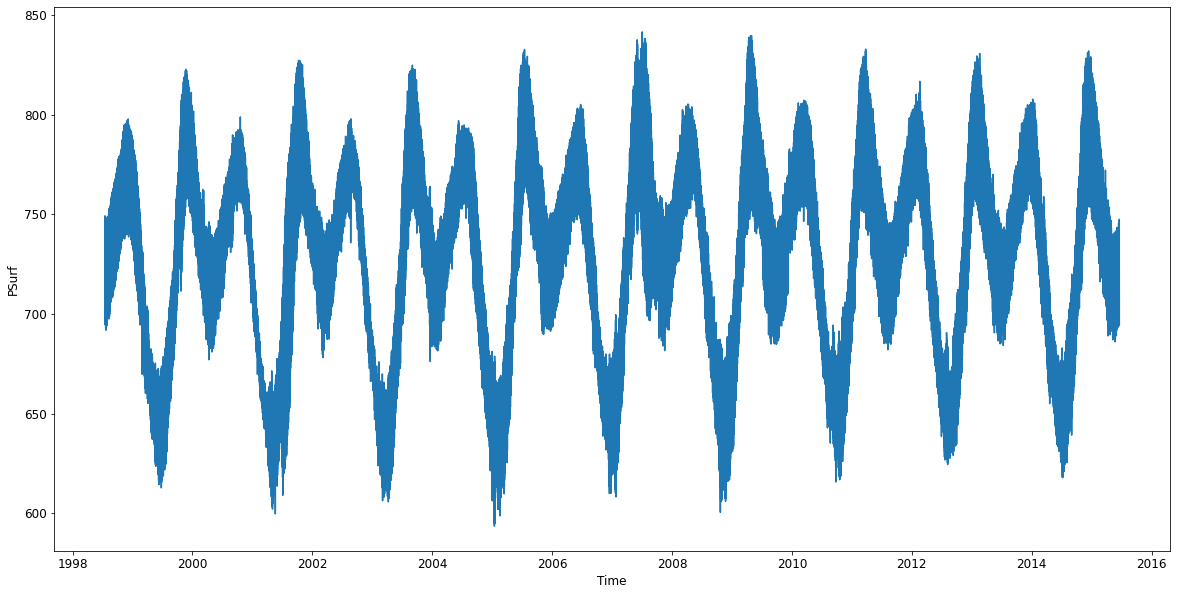

In [2]:
df.groupby(pd.Grouper(key='Time',freq='W')).mean()

df.info()


# Convention for import of the pyplot interface
import matplotlib.pyplot as plt

# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline

plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(20, 10))

# Specify how our lines should look
ax.plot(df.Time, df.Psurf, color='tab:blue', label='Psurf')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('PSurf')

Load Test Data

In [3]:
import numpy as np
df_test= pd.read_csv('data/insight_openmars_test_time.csv')
df_test.drop(['Ls','LT','CO2ice'],axis=1,inplace=True)
target = df_test['Psurf']
df_test.drop(labels=['Psurf'], axis=1,inplace = True)
df_test.insert(1, 'Psurf', target)
df_test.insert(2, 'Psurf_predict',df_test.Psurf+np.random.randint(-5, 5, 16364),)

df_test['Time']= pd.to_datetime(df_test['Time'])



Learning

In [4]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler


%matplotlib inline

plt.rc('font', size=12)

# Specify how our lines should look
ax.plot(df_test.Time, df_test.Psurf, color='tab:blue', label='Psurf')
ax.plot(df_test.Time, df_test.Psurf_predict, color='tab:orange', label='Psurf_predict')

# Same as above
ax.set_xlabel('Time')
ax.set_ylabel('PSurf')


scalers={}
for i in df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(df[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    df[i]=s_s
for i in df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(df_test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    df_test[i]=s_s



# early_stop=EarlyStopping(monitor='loss',patience=5)

# model=Sequential([Conv1D(100,kernel_size=3,input_shape=(30,1),activation='relu'),
#                   Conv1D(100,kernel_size=3),
#                   Conv1D(100,kernel_size=3),
#                   MaxPooling1D(2),
#                  Flatten(),
#                   RepeatVector(30),
#                  LSTM(128,activation='relu',return_sequences=True),
#                  LSTM(128,activation='relu',return_sequences=True),
#                   Bidirectional(LSTM(64,activation='relu')),
#                  Dense(128,activation='relu'),
#                  Dense(1)])

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  #tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True)),
  tf.keras.layers.Dropout(0.15),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, activation='relu', return_sequences=True)),
  tf.keras.layers.Dropout(0.15),

  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


# model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

steps=30
inp1=[]
out1=[]

for i in range(len(df)-steps):
    inp1.append(df[i:i+steps])
    out1.append(df[i+steps])

inp1=np.asanyarray(inp1)
out1=np.asanyarray(out1)
x_train1=inp1[:500,:,:]
x_test1=inp1[500:,:,:]
y_train1=out1[:500]
y_test1=out1[500:]

model.fit(x_train1,y_train1,epochs=20)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
# #optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
# optimizer = tf.keras.optimizers.Adam()
#
# model.compile(loss=tf.keras.losses.Huber(),
#               optimizer=optimizer,
#               metrics=["mae"])
# history = model.fit(df, epochs=155, callbacks=[lr_schedule])


2022-02-08 12:23:16.181591: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


KeyError: 30